# Codes

In [1]:
!pip install torch-geometric
!pip install POT

In [1]:
import torch
import numpy as np
import networkx as nx
import functools
from torch_geometric.utils import (
    to_networkx,
    from_networkx,
)
import ot

In [2]:
class CalculationGraph(nx.Graph):
    '''Graph class inherited from the NetworkX Graph class with extra methods for calculating curvature'''

    def visualize_edge(self, edge):
        # Get the local neighborhood
        u, v = edge
        local_neighbors = set()
        local_neighbors = local_neighbors | set(self.neighbors(u)) | set(self.neighbors(v))

        # Add points that form a pentagon with regard to the edge
        pent_nodes = set()
        seen_nodes = local_neighbors.copy()
        for p in self.neighbors(u):
            for q in self.neighbors(p):
                if q in seen_nodes: 
                    continue
                seen_nodes.add(q)
                flag = False
                for w in self.neighbors(v):
                    if (q,w) in self.edges and w != p:
                        flag = True
                        continue
                if flag:
                    pent_nodes.add(q)
        
        # Draw the induced subgraph
        local_neighborhood = local_neighbors | pent_nodes
        labels = {}
        for node in local_neighborhood:
            labels[node] = ''
        labels[u] = u
        labels[v] = v
        local_neighborhood = self.subgraph(local_neighborhood)        
        nx.draw_networkx(local_neighborhood, labels = labels)
    
    @functools.cache
    def get_dijkstra_path(self, u, v):
        return nx.single_source_dijkstra(self, u, v)

    def sobolev_transport_1_hop(self, u, v):
        if (u,v) not in self.edges:
            raise LookupError(f'There is no edge between nodes {edge[0]} and {edge[1]}')

        u_neighbors = list(self.neighbors(u)) + [u]
        v_neighbors = list(self.neighbors(v)) + [v]
        support = list(set(u_neighbors + v_neighbors))

        # Calculate shortest paths
        path_dict = {}
        edge_set = set()
        for neighbor in support:
            __, path_vertex = self.get_dijkstra_path(u, neighbor)
            path_edge = [(path_vertex[i], path_vertex[i+1]) for i in range(len(path_vertex)-1)]
            path_dict[neighbor] = path_edge
            edge_set.update(path_edge)
        edge_list = list(edge_set)

        # Define the computational matrix h
        h = np.zeros((len(support), len(edge_list)))
        for node in support:
            for edge in path_dict[node]:
                h[support.index(node)][edge_list.index(edge)] = 1

        # Define the measure
        neighbor_mass_u = 1/len(u_neighbors)
        neighbor_mass_v = 1/len(v_neighbors)
        measure_u = np.zeros(len(support))
        measure_v = np.zeros(len(support))
        for node in support:
            if node in u_neighbors:
                measure_u[support.index(node)] = neighbor_mass_u
            if node in v_neighbors:
                measure_v[support.index(node)] = neighbor_mass_v

        H_u = np.matmul(h.T, measure_u)
        H_v = np.matmul(h.T, measure_v)

        return np.linalg.norm((H_u - H_v), ord=1)

    @functools.cache
    def wasserstein_transport_1_hop(self, u, v):
        # Get general neighborhood informations
        u_neighbors = list(self.neighbors(u)) + [u]
        v_neighbors = list(self.neighbors(v)) + [v]
        deg_u = len(u_neighbors)
        deg_v = len(v_neighbors)

        # Define the measure
        neighbor_mass_u = 1/deg_u
        neighbor_mass_v = 1/deg_v
        measure_u = np.ones(deg_u) * 1/deg_u
        measure_v = np.ones(deg_v) * 1/deg_v
        # measure_u = np.zeros(deg_u)
        # measure_v = np.zeros(deg_v)
        # for node in u_neighbors:
        #     measure_u[u_neighbors.index(node)] = neighbor_mass_u
        # for node in v_neighbors:
        #     measure_v[v_neighbors.index(node)] = neighbor_mass_v
        # print(deg_u, deg_v, measure_u, measure_v)
        # print(np.sum(measure_u), np.sum(measure_v))

        # Define the distance matrix
        distance_matrix = np.full((deg_u, deg_v), np.inf)
        for node_1 in u_neighbors:
            for node_2 in v_neighbors:
                index = (u_neighbors.index(node_1), v_neighbors.index(node_2))
                if distance_matrix[index] == np.inf:
                    distance_matrix[index], __ = self.get_dijkstra_path(node_1, node_2)
        return ot.emd2(measure_u, measure_v, distance_matrix)

In [3]:
def convert_graph(pyg_graph):
    graph = to_networkx(pyg_graph.data)
    return CalculationGraph(graph)

# Examples

In [3]:
from torch_geometric.datasets import KarateClub, Planetoid
import pandas as pd
import time

In [6]:
karate_club_graph = to_networkx(KarateClub().data)
karate_club_graph = CalculationGraph(karate_club_graph)

/home/khang/miniconda3/envs/borf/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [11]:
all_diff = []
try:
    f = open('KarateClub_edge_list.txt', 'w')
    for edge in karate_club_graph.edges:
        # sobolev_distance = (test_graph.sobolev_transport_1_hop(*edge) + test_graph.sobolev_transport_1_hop(*edge[::-1]))/2
        sobolev_distance = karate_club_graph.sobolev_transport_1_hop(*edge)
        wasserstein_distance = karate_club_graph.wasserstein_transport_1_hop(*edge)
        diff = abs(sobolev_distance - wasserstein_distance)
        all_diff.append(diff)
        f.write(f'{edge} {wasserstein_distance} {sobolev_distance} {diff} \n')
finally:
    f.close()
df_describe = pd.DataFrame(all_diff)
df_describe.describe()

,0
count,7.800000e+01
mean,2.831867e-01
std,1.880369e-01
min,2.220446e-16
25%,1.428571e-01
50%,2.341880e-01
75%,4.375566e-01
max,9.166667e-01


In [8]:
test_graph = Planetoid(root = 'data', name = 'cora')
test_graph = NXGraph(test_graph)
test_graph.get_dijkstra_path.cache_clear()
test_graph.wasserstein_transport_1_hop.cache_clear()
try:
    print('Testing: Sobolev_distance')
    f = open('Cora_edge_list_sobolev.txt', 'a')
    start_time = time.time()
    for edge in test_graph.edges:
        sobolev_distance = test_graph.sobolev_transport_1_hop(*edge)
        f.write(f'{edge} {sobolev_distance} \n')
    end_time = time.time()
    f.write(f'That took {end_time - start_time} to complete.')
    print(f'That took {end_time - start_time} to complete.')
finally:
    f.close()

test_graph.get_dijkstra_path.cache_clear()
test_graph.wasserstein_transport_1_hop.cache_clear()
try:
    print('Testing: Wasserstein_distance')
    f = open('Cora_edge_list_wasserstein.txt', 'a')
    start_time = time.time()
    for edge in test_graph.edges:
        wasserstein_distance = test_graph.wasserstein_transport_1_hop(*edge)
        f.write(f'{edge} {wasserstein_distance} \n')
    end_time = time.time()
    f.write(f'That took {end_time - start_time} to complete.')
    print(f'That took {end_time - start_time} to complete.')
finally:
    f.close()

NameError: name 'NXGraph' is not defined

# Experiments

## Compare the edge values between the two types of distances

In [4]:
from torch_geometric.datasets import WebKB, WikipediaNetwork, Actor, Planetoid
import pandas as pd
import time

In [9]:
cornell = WebKB(root="data", name="Cornell")
wisconsin = WebKB(root="data", name="Wisconsin")
texas = WebKB(root="data", name="Texas")
# chameleon = WikipediaNetwork(root="data", name="chameleon")
cora = Planetoid(root="data", name="cora")
citeseer = Planetoid(root="data", name="citeseer")
datasets = {"cora": cora, "cornell": cornell, "wisconsin": wisconsin, "texas": texas, 
        # "chameleon": chameleon,
        "citeseer": citeseer}
dist_types = {'sobolev', 'wasserstein', 'sobolev_average'}

In [10]:
import warnings
warnings.filterwarnings('ignore')
for dataset in datasets:
    for dist_type in dist_types:
        try:
            print(f"Starting_{dataset}_{dist_type}")
            graph = convert_graph(datasets[dataset])
            dist_list = []
            start = time.time()
            if dist_type == 'wasserstein':
                for edge in graph.edges:
                    dist_list.append(graph.wasserstein_transport_1_hop(*edge))
            elif dist_type == 'sobolev':
                for edge in graph.edges:
                    dist_list.append(graph.sobolev_transport_1_hop(*edge))
            elif dist_type == 'sobolev_average':
                for edge in graph.edges:
                    dist = (graph.sobolev_transport_1_hop(*edge) + graph.sobolev_transport_1_hop(*edge[::-1]))/2
                    dist_list.append(dist)
            for edge in graph.edges:
                dist = (graph.sobolev_transport_1_hop(*edge) + graph.sobolev_transport_1_hop(*edge[::-1]))/2
                dist_list.append(dist)
            end = time.time()
            elapsed = end-start
            if elapsed >= 60:
                minutes, seconds = divmod(elapsed, 60)
            else:
                minutes = 0
                seconds = elapsed
            d = {'edge': graph.edges, 'dist': dist_list}
        except:
            print(f"Error_{dataset}_{dist_type}")
            continue
        else:
            df = pd.DataFrame(data = d).sort_values('dist')
            df.to_csv(f"dist_comparision/{dataset}_{dist_type}_{int(minutes)}m{int(seconds)}s")
            print(f"Completed_{dataset}_{dist_type}_{int(minutes)}m_{int(seconds)}s")

Starting_cora_sobolev_average
Completed_cora_sobolev_average_0m_-10s
Starting_cora_wasserstein
Completed_cora_sobolev_average_0m_-10s
Starting_cora_sobolev
Completed_cora_sobolev_average_0m_-10s
Starting_cornell_sobolev_average
Completed_cornell_sobolev_average_0m_0s
Starting_cornell_wasserstein
Completed_cornell_sobolev_average_0m_0s
Starting_cornell_sobolev
Completed_cornell_sobolev_average_0m_0s
Starting_wisconsin_sobolev_average
Completed_wisconsin_sobolev_average_0m_-1s
Starting_wisconsin_wasserstein
Completed_wisconsin_sobolev_average_0m_-1s
Starting_wisconsin_sobolev
Completed_wisconsin_sobolev_average_0m_-1s
Starting_texas_sobolev_average
Completed_texas_sobolev_average_0m_0s
Starting_texas_wasserstein
Completed_texas_sobolev_average_0m_0s
Starting_texas_sobolev
Completed_texas_sobolev_average_0m_0s
Starting_citeseer_sobolev_average
Completed_citeseer_sobolev_average_0m_-3s
Starting_citeseer_wasserstein
Completed_citeseer_sobolev_average_0m_-3s
Starting_citeseer_sobolev
Complet

In [155]:
graph = convert_graph(citeseer)

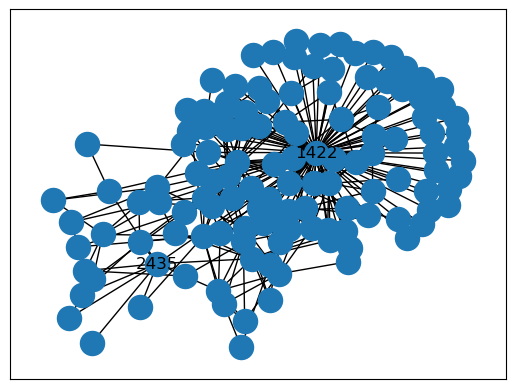

In [184]:
graph.visualize_edge((1422, 2435))

## Run the GNN

# Thoughts

It's still unclear how we might approach the problem of using the Sobolev transport to detect over-squashing.

Interesting note: This paper [Tree! I am no Tree! I am a Low Dimensional
Hyperbolic Embedding](https://proceedings.neurips.cc/paper/2020/file/093f65e080a295f8076b1c5722a46aa2-Paper.pdf) learn a tree that essentially preserves the distances amongst the data points and then embed
this tree into hyperbolic space. What if we combine this paper and the Tree Wasserstein paper to produce something that operates on (hierachical) data.